### ML project - preprocessing and MLP part

In [1]:
# doing this part as the codes are gonna be run in google colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Phase 1 : row data import and diagnostics**

In [2]:
# our dataset type is ulog
ULOG_PATH = "/content/drive/MyDrive/Colab Notebooks/ML/data.ulg"

importing the dataset by using pyulog

In [3]:
!pip install pyulog

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.0/49.0 kB 1.9 MB/s eta 0:00:00


In [4]:
from pyulog import ULog
import pandas as pd
import numpy as np

In [5]:
ulog = ULog(ULOG_PATH)

In [6]:
print("Topics in this ULog:")
for d in ulog.data_list:
    print(f"- {d.name}")

Topics in this ULog:
- action_request
- actuator_armed
- actuator_motors
- actuator_outputs
- actuator_outputs
- battery_status
- config_overrides
- control_allocator_status
- cpuload
- distance_sensor
- estimator_aid_src_baro_hgt
- estimator_aid_src_gnss_hgt
- estimator_aid_src_gnss_pos
- estimator_aid_src_gnss_vel
- estimator_aid_src_gravity
- estimator_aid_src_mag
- estimator_aid_src_rng_hgt
- estimator_baro_bias
- estimator_event_flags
- estimator_gnss_hgt_bias
- estimator_gps_status
- estimator_innovation_test_ratios
- estimator_innovation_variances
- estimator_innovations
- estimator_sensor_bias
- estimator_states
- estimator_status
- estimator_status_flags
- event
- failsafe_flags
- failure_detector_status
- gps_dump
- home_position
- hover_thrust_estimate
- input_rc
- magnetometer_bias_estimate
- manual_control_setpoint
- manual_control_switches
- mission_result
- navigator_mission_item
- parameter_update
- position_setpoint_triplet
- rate_ctrl_status
- rtl_status
- rtl_time_es

In [7]:
def ulog_topic_to_df(ulog, topic_name):
    """
    PX4 ULog topic → pandas DataFrame change
    index = timestamp (if available)
    """
    #finding dataset using name
    datasets = [ds for ds in ulog.data_list if ds.name == topic_name]
    if not datasets:
        raise ValueError(f"Topic '{topic_name}' not found in ULog")
    d = datasets[0]

    #values of field in d.data
    #    ex: {'timestamp': array(...), 'q[0]': array(...), ...}
    data = {k: v for k, v in d.data.items()}

    df = pd.DataFrame(data)

    #if we find timestamp it will be used as an index
    if 'timestamp' in df.columns:
        df = df.set_index('timestamp')

    return df



Selected topics for the machine learning dataset

For the inputs, the dataset mainly relies on onboard sensor information coming from the vehicle. This includes IMU data such as accelerometer and gyroscope measurements, as well as angular velocity and attitude expressed as quaternions.

The outputs correspond to the commands sent to the motors. These values can be taken either from the actuator_outputs topic or directly from actuator_motors when motor commands are logged there.



In [8]:
topics = {
    "attitude": "vehicle_attitude",
    "angvel": "vehicle_angular_velocity",
    "imu": "vehicle_imu",
    "motors": "actuator_outputs"
}

dfs = {}

for key, topic in topics.items():
    try:
        dfs[key] = ulog_topic_to_df(ulog, topic)
        print(f"Loaded {topic} → df['{key}'] shape = {dfs[key].shape}")
    except Exception as e:
        print(f"Topic {topic} NOT FOUND :: {e}")


Loaded vehicle_attitude → df['attitude'] shape = (436817, 10)
Loaded vehicle_angular_velocity → df['angvel'] shape = (624563, 7)
Loaded vehicle_imu → df['imu'] shape = (4372, 15)
Loaded actuator_outputs → df['motors'] shape = (21861, 17)


The log looks good, all four topics were found and converted into dataframes, so we can actually work with them.

vehicle_attitude and vehicle_angular_velocity are the “main” high-rate signals here (hundreds of thousands of rows), so they’re strong candidates for the input features. vehicle_imu exists too, but in this file it’s much shorter, so we’ll treat it as optional unless we resample/align everything later.

actuator_outputs is what we care about for the target, it contains the motor command signals (PWM or normalized outputs).
From a supervised MLP point of view, the idea is simple: we’ll feed attitude + angular rates (and maybe a few IMU fields) as X, and we’ll predict the motor-related columns inside actuator_outputs as y (we’ll pick the exact M1–M4 columns in the next step).

In [9]:
#phase 1.3 exploring the dataset
def describe_topic(df, name):
    t0 = df.index[0]
    t1 = df.index[-1]
    duration_s = (t1 - t0) / 1e6   # PX4 timestamp should be µs
    freq_hz = len(df) / duration_s

    print(f"=== {name} ===")
    print(f"rows      : {len(df)}")
    print(f"duration  : {duration_s:.1f} s (~{duration_s/60:.1f} min)")
    print(f"approx Hz : {freq_hz:.1f} Hz")
    print()

describe_topic(dfs["attitude"], "attitude")
describe_topic(dfs["angvel"],   "angular velocity")
describe_topic(dfs["imu"],      "imu")
describe_topic(dfs["motors"],   "motors")


=== attitude ===
rows      : 436817
duration  : 2184.1 s (~36.4 min)
approx Hz : 200.0 Hz

=== angular velocity ===
rows      : 624563
duration  : 2186.0 s (~36.4 min)
approx Hz : 285.7 Hz

=== imu ===
rows      : 4372
duration  : 2185.5 s (~36.4 min)
approx Hz : 2.0 Hz

=== motors ===
rows      : 21861
duration  : 2185.9 s (~36.4 min)
approx Hz : 10.0 Hz



We extracted the main PX4 topics of interest: vehicle attitude (≈200 Hz), angular velocity (≈280 Hz), IMU data (2 Hz), and actuator outputs (10 Hz). The total flight duration is approximately 36 minutes, and the sampling rates are consistent with expected PX4 logging behavior. Overall, the dataset provides dense, high-frequency state information, making it well suited for supervised learning tasks as well as reinforcement learning pretraining.

# **phase 2 : basic cleaning**

In [10]:
#phase 2.1 remove startup/shutdown
mot_df = dfs["motors"]
mot_df.columns

Index(['noutputs', 'output[0]', 'output[1]', 'output[2]', 'output[3]',
       'output[4]', 'output[5]', 'output[6]', 'output[7]', 'output[8]',
       'output[9]', 'output[10]', 'output[11]', 'output[12]', 'output[13]',
       'output[14]', 'output[15]'],
      dtype='object')

In [11]:
mot_df = dfs["motors"].copy()

# Select only the columns that look like motor outputs
motor_cols = [c for c in mot_df.columns if "[" in c and "]" in c]
print("Motor candidate columns:", motor_cols)

# Define motor activity using the mean absolute motor power
motor_power = mot_df[motor_cols].abs().mean(axis=1)

# Setting a threshold (0.01 for normalized values; for PWM this could be around 50–100)
THRESH = motor_power.max() * 0.05  #consider it "flying" if above 5% of the max
active_mask = motor_power > THRESH

print("Active samples:", active_mask.sum(), " / total:", len(active_mask))


Motor candidate columns: ['output[0]', 'output[1]', 'output[2]', 'output[3]', 'output[4]', 'output[5]', 'output[6]', 'output[7]', 'output[8]', 'output[9]', 'output[10]', 'output[11]', 'output[12]', 'output[13]', 'output[14]', 'output[15]']
Active samples: 16878  / total: 21861


In [12]:
# start and end timestamp of active area
active_ts = mot_df.index[active_mask]
t_start = active_ts[0]
t_end   = active_ts[-1]

print("Flight window:")
print(" start:", t_start)
print(" end  :", t_end)
print(" duration (s):", (t_end - t_start) / 1e6)

Flight window:
 start: 436106480
 end  : 2164906480
 duration (s): 1728.8


In [13]:
def trim_df(df, t_start, t_end):
    return df[(df.index >= t_start) & (df.index <= t_end)]

att_trim = trim_df(dfs["attitude"], t_start, t_end)
ang_trim = trim_df(dfs["angvel"],   t_start, t_end)
imu_trim = trim_df(dfs["imu"],      t_start, t_end)
mot_trim = trim_df(dfs["motors"],   t_start, t_end)

print("att_trim:", att_trim.shape)
print("ang_trim:", ang_trim.shape)
print("imu_trim:", imu_trim.shape)
print("mot_trim:", mot_trim.shape)


att_trim: (345760, 10)
ang_trim: (493942, 7)
imu_trim: (3457, 15)
mot_trim: (17289, 17)


We filter the dataframes using their time index so that only samples between t_start and t_end are kept. The same time interval is applied consistently to attitude, angular velocity, IMU, and motor signals, ensuring all topics are temporally aligned for subsequent analysis.

In [14]:
dfs_trim = {
    "attitude": att_trim,
    "angvel":   ang_trim,
    "imu":      imu_trim,
    "motors":   mot_trim,
}

In [15]:
# phase 2.2 remove or correct corrupt data
att_trim = dfs_trim["attitude"]
ang_trim = dfs_trim["angvel"]
imu_trim = dfs_trim["imu"]
mot_trim = dfs_trim["motors"]


In [16]:
def check_basic_stats(name, df):
    print(f"\n=== {name} ===")
    print("shape:", df.shape)
    print("NaNs per column:")
    print(df.isna().sum())
    print("Any inf? ->", np.isinf(df.to_numpy()).any())

check_basic_stats("attitude", att_trim)
check_basic_stats("angular_velocity", ang_trim)
check_basic_stats("imu", imu_trim)
check_basic_stats("motors", mot_trim)


=== attitude ===
shape: (345760, 10)
NaNs per column:
timestamp_sample      0
q[0]                  0
q[1]                  0
q[2]                  0
q[3]                  0
delta_q_reset[0]      0
delta_q_reset[1]      0
delta_q_reset[2]      0
delta_q_reset[3]      0
quat_reset_counter    0
dtype: int64
Any inf? -> False

=== angular_velocity ===
shape: (493942, 7)
NaNs per column:
timestamp_sample     0
xyz[0]               0
xyz[1]               0
xyz[2]               0
xyz_derivative[0]    0
xyz_derivative[1]    0
xyz_derivative[2]    0
dtype: int64
Any inf? -> False

=== imu ===
shape: (3457, 15)
NaNs per column:
timestamp_sample           0
accel_device_id            0
gyro_device_id             0
delta_angle[0]             0
delta_angle[1]             0
delta_angle[2]             0
delta_velocity[0]          0
delta_velocity[1]          0
delta_velocity[2]          0
delta_angle_dt             0
delta_velocity_dt          0
delta_angle_clipping       0
delta_velocity_clipping 

No NaN existing, don't need to do dropna

In [17]:
motor_cols = [c for c in mot_trim.columns if "output[" in c]

mot_trim[motor_cols].describe()

,output[0],output[1],output[2],output[3],output[4],output[5],output[6],output[7],output[8],output[9],output[10],output[11],output[12],output[13],output[14],output[15]
count,17289.000000,17289.000000,17289.000000,17289.000000,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0,17289.0
mean,870.914429,1022.550659,936.993042,956.497803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,185.097092,203.625031,187.510147,198.394470,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,813.000000,978.000000,887.000000,902.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,879.000000,1038.000000,950.000000,970.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,968.000000,1124.000000,1032.000000,1053.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1439.000000,1617.000000,1485.000000,1652.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Actually used motros are 0 to 3
we can drop the others they are unnecessary.

In [18]:
att_trim.describe()
ang_trim.describe()

,timestamp_sample,xyz[0],xyz[1],xyz[2],xyz_derivative[0],xyz_derivative[1],xyz_derivative[2]
count,4.939420e+05,493942.000000,493942.000000,493942.000000,493942.000000,493942.000000,493942.000000
mean,1.300507e+09,-0.000424,0.006135,-0.069644,-0.000791,0.001106,-0.000051
std,4.990621e+08,0.097916,0.110979,0.236869,2.367137,1.909601,1.472042
min,4.361101e+08,-0.805752,-0.711145,-1.040724,-18.183025,-22.041777,-37.325474
25%,8.683085e+08,-0.027904,-0.028836,-0.010225,-1.412326,-1.138055,-0.728929
50%,1.300507e+09,-0.000295,-0.000745,-0.000747,0.002620,0.005646,0.002128
75%,1.732705e+09,0.026299,0.024991,0.007290,1.420398,1.146637,0.732337
max,2.164906e+09,0.758143,0.760777,1.012903,18.359346,21.199780,30.561916


No such anomly detected. The values seem to be coherent.

In [19]:
#phase 2.3 checking timestamp
def check_timestamp_monotonic(name, df):
    idx = df.index
    diffs = idx.to_series().diff().dropna()
    print(f"=== {name} ===")
    print("is_monotonic:", idx.is_monotonic_increasing)
    print("any non-positive step?:", (diffs <= 0).any())
    print("min step (µs):", diffs.min())
    print("max step (µs):", diffs.max())
    print()

check_timestamp_monotonic("attitude", att_trim)
check_timestamp_monotonic("angular_velocity", ang_trim)
check_timestamp_monotonic("motors", mot_trim)

=== attitude ===
is_monotonic: True
any non-positive step?: False
min step (µs): 2755.0
max step (µs): 6129.0

=== angular_velocity ===
is_monotonic: True
any non-positive step?: False
min step (µs): 1246.0
max step (µs): 7505.0

=== motors ===
is_monotonic: True
any non-positive step?: False
min step (µs): 94994.0
max step (µs): 105010.0



Attitude and angular velocity are logged at relatively high and comparable rates, while motor outputs are logged at a much lower rate with larger time gaps.

non-positive step = false = evey timesteps are correct.

# **phase 3 : time alignement and sampling**

In [20]:
#phase 3.1 unify sampling rates
#resampling we are using only 4 motors (0 to 3)
motor_cols_use = ['output[0]', 'output[1]', 'output[2]', 'output[3]']
mot_10 = mot_trim[motor_cols_use].copy()

print(mot_10.shape)

(17289, 4)


In [21]:
target_index = mot_10.index  # 10 Hz timeline
len(target_index)

17289

In [22]:
# downsampling the attitude and angluar velocity to match this timeline
# nearest matching from high frequency to low frequency (200/280 Hz to 10Hz)
att_r = att_trim.reindex(target_index, method='nearest')
ang_r = ang_trim.reindex(target_index, method='nearest')

print("att_r:", att_r.shape)
print("ang_r:", ang_r.shape)

att_r: (17289, 10)
ang_r: (17289, 7)


In [23]:
# deleting non necessary timestamp_sample
if 'timestamp_sample' in att_r.columns:
    att_r = att_r.drop(columns=['timestamp_sample'])

if 'timestamp_sample' in ang_r.columns:
    ang_r = ang_r.drop(columns=['timestamp_sample'])

In [24]:
mot_10.shape, att_r.shape, ang_r.shape

((17289, 4), (17289, 9), (17289, 6))

In [25]:
# phase 3.2 resample and interpolate all streams
# X=feature=att_r+ang_r
#y=labels=mot_10
att_features = att_r.add_prefix("att_")   # att_q[0], att_delta_q_reset[0] ...
ang_features = ang_r.add_prefix("rate_")  # rate_xyz[0], rate_derivative[0] ...


# Feature matrix
X = pd.concat([att_features, ang_features], axis=1)

# Target matrix (labels)
y = mot_10.copy()
y = y.rename(columns={
    'output[0]': 'm1',
    'output[1]': 'm2',
    'output[2]': 'm3',
    'output[3]': 'm4',
})

In [26]:
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (17289, 15)
y shape: (17289, 4)


In [27]:
#rechecking NaN
print("X NaNs:", X.isna().sum().sum())
print("y NaNs:", y.isna().sum().sum())
print("Any inf in X?:", np.isinf(X.to_numpy()).any())
print("Any inf in y?:", np.isinf(y.to_numpy()).any())


X NaNs: 0
y NaNs: 0
Any inf in X?: False
Any inf in y?: False


In [28]:
#registering in the dictionnary
data_aligned = {
    "X": X,
    "y": y,
}

X.head(), y.head()

(           att_q[0]  att_q[1]  att_q[2]  att_q[3]  att_delta_q_reset[0]  \
 timestamp                                                                 
 436106480  0.865317  0.006537  0.003483  0.501171              0.999994   
 436207726  0.865336  0.006517  0.003474  0.501137              0.999994   
 436306485  0.865057  0.006530  0.003772  0.501618              0.999994   
 436407771  0.865240  0.006588  0.003930  0.501299              0.999994   
 436505232  0.865155  0.006887  0.003933  0.501442              0.999994   
 
            att_delta_q_reset[1]  att_delta_q_reset[2]  att_delta_q_reset[3]  \
 timestamp                                                                     
 436106480          1.303596e-10          4.341548e-10              0.003489   
 436207726          1.303596e-10          4.341548e-10              0.003489   
 436306485          1.303596e-10          4.341548e-10              0.003489   
 436407771          1.303596e-10          4.341548e-10            

Each row corresponds to one timestep.
The inputs describe the drone state: attitude as a quaternion (att_q[0..3]), angular rates (rate_xyz for roll, pitch, yaw), and their derivatives, which capture how fast the rotation is changing. The reset-related fields are mostly constant and mainly indicate internal estimator resets.

The outputs are the motor commands m1 to m4, corresponding to output[0] through output[3].
In a supervised setting, the goal is to map the state variables to these motor outputs.

In [29]:
# PHASE 3.2 final feature matix X & target matrix y
att_features = att_r.add_prefix("att_")
ang_features = ang_r.add_prefix("rate_")


In [30]:
#combining 2 dfs

X = pd.concat([att_features, ang_features], axis=1)
print("X shape:", X.shape)


X shape: (17289, 15)


In [31]:
# creating y= target labels
y = mot_10.copy()
y = y.rename(columns={
    'output[0]': 'm1',
    'output[1]': 'm2',
    'output[2]': 'm3',
    'output[3]': 'm4',
})
print("y shape:", y.shape)


y shape: (17289, 4)


In [32]:
print("X NaNs:", X.isna().sum().sum())
print("y NaNs:", y.isna().sum().sum())
print("Any inf in X?:", np.isinf(X.to_numpy()).any())
print("Any inf in y?:", np.isinf(y.to_numpy()).any())

X NaNs: 0
y NaNs: 0
Any inf in X?: False
Any inf in y?: False


In [33]:
data_aligned = {
    "X": X,
    "y": y,
}

In [34]:
# phase 3.3
#as an example roll-rate vs motor1 (just checking)
feat = X['rate_xyz[0]']
m1   = y['m1']

def lag_corr(x, y, lag_steps):
    if lag_steps > 0:
        x_l = x.iloc[:-lag_steps]
        y_l = y.iloc[lag_steps:]
    elif lag_steps < 0:
        x_l = x.iloc[-lag_steps:]
        y_l = y.iloc[:lag_steps]
    else:
        x_l = x
        y_l = y
    return np.corrcoef(x_l, y_l)[0, 1]

for lag in [-2, -1, 0, 1, 2]:
    c = lag_corr(feat, m1, lag)
    print(f"lag {lag}: corr = {c:.4f}")


lag -2: corr = -0.0236
lag -1: corr = -0.0493
lag 0: corr = -0.0745
lag 1: corr = -0.0560
lag 2: corr = -0.0425


We empirically tested potential actuation latency using lagged correlations between state features and motor outputs. No clear peak at ±1 time step was observed (all correlations remained close to 0), so we kept the natural PX4 timestamp alignment: state(t) → motors(t).

# **phase 4 : signal refinement**

In [35]:
# phase 4.1 noise reduction

We chose not to apply additional filtering to attitude and angular rate signals, as these values are already states estimated by the PX4 EKF (high-quality, low-noise). Additional smoothing (low-pass or moving averages) would introduce artificial lag that could harm the learning of fast control dynamics.

<Axes: xlabel='timestamp'>

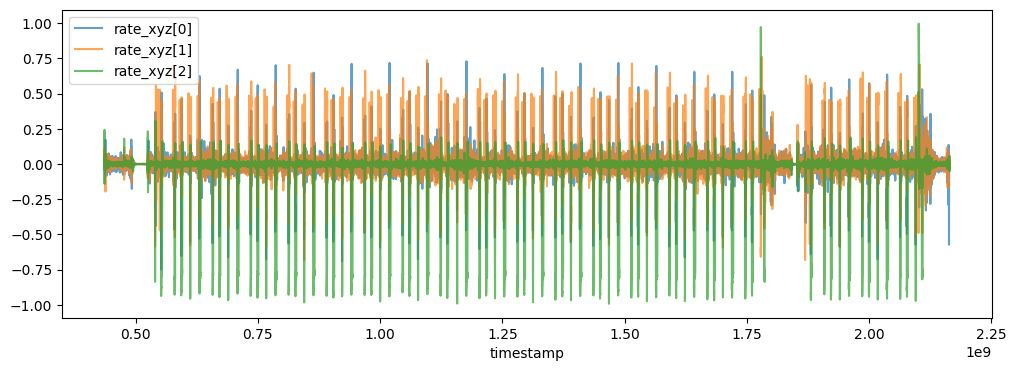

In [36]:
# we are going to do the least of the noise check by visualizing it
X[['rate_xyz[0]', 'rate_xyz[1]', 'rate_xyz[2]']].plot(figsize=(12,4), alpha=0.7)

The strong, fast oscillations in the angular rates come mainly from the flight controller constantly correcting the drone’s attitude. Small errors trigger rapid PID corrections, which can lead to slight overshoots and continuous back-and-forth adjustments visible in the data. Motor and propeller vibrations also add noise to the IMU signals. The sharp peaks likely correspond to more aggressive maneuvers, while the calmer interval around 1.75–2.0 suggests a more stable phase, such as hovering or reduced pilot input.

The angular rate measurements exhibit regular oscillatory patterns corresponding to the drone’s control loop activity, with no significant high-frequency noise or sensor corruption. Since these signals are already EKF-filtered by PX4, additional smoothing would add unnecessary lag, therefore, no extra filtering is applied.

In [37]:
# phase 4.2 coordinate frame standardization

Attitude is represented by a unit quaternion att_q[0..3] (PX4 EKF output).

Angular rates rate_xyz[0..2] are expressed in rad/s in the body frame.

Motor commands m1..m4 are raw PWM values in the range ≈ 1000–1600.
We keep these native units and coordinate frames to avoid extra transformations that might distort the control dynamics.

In [38]:
def quat_to_euler(q0, q1, q2, q3):
    # PX4 convention: q = [w, x, y, z] = [q0, q1, q2, q3]
    # roll, pitch, yaw (rad)
    # roll (x-axis)
    sinr_cosp = 2 * (q0*q1 + q2*q3)
    cosr_cosp = 1 - 2 * (q1*q1 + q2*q2)
    roll = np.arctan2(sinr_cosp, cosr_cosp)

    # pitch (y-axis)
    sinp = 2 * (q0*q2 - q3*q1)
    pitch = np.where(
        np.abs(sinp) >= 1,
        np.sign(sinp) * (np.pi/2),
        np.arcsin(sinp)
    )

    # yaw (z-axis)
    siny_cosp = 2 * (q0*q3 + q1*q2)
    cosy_cosp = 1 - 2 * (q2*q2 + q3*q3)
    yaw = np.arctan2(siny_cosp, cosy_cosp)

    return roll, pitch, yaw

# tacking only quaternion to create a Euler angle row
q0 = X['att_q[0]'].to_numpy()
q1 = X['att_q[1]'].to_numpy()
q2 = X['att_q[2]'].to_numpy()
q3 = X['att_q[3]'].to_numpy()

roll, pitch, yaw = quat_to_euler(q0, q1, q2, q3)

X['att_roll']  = roll
X['att_pitch'] = pitch
X['att_yaw']   = yaw

In [39]:
print(X[['att_q[0]', 'att_q[1]', 'att_q[2]', 'att_q[3]',
         'att_roll', 'att_pitch', 'att_yaw']].head())


deg_roll  = np.rad2deg(X['att_roll'])
deg_pitch = np.rad2deg(X['att_pitch'])
deg_yaw   = np.rad2deg(X['att_yaw'])

print("\nRoll range (deg): ",  deg_roll.min(),  "→", deg_roll.max())
print("Pitch range (deg):",  deg_pitch.min(), "→", deg_pitch.max())
print("Yaw range (deg):  ",  deg_yaw.min(),   "→", deg_yaw.max())

           att_q[0]  att_q[1]  att_q[2]  att_q[3]  att_roll  att_pitch  \
timestamp                                                                
436106480  0.865317  0.006537  0.003483  0.501171  0.014804  -0.000524   
436207726  0.865336  0.006517  0.003474  0.501137  0.014761  -0.000519   
436306485  0.865057  0.006530  0.003772  0.501618  0.015082  -0.000026   
436407771  0.865240  0.006588  0.003930  0.501299  0.015341   0.000197   
436505232  0.865155  0.006887  0.003933  0.501442  0.015861  -0.000102   

            att_yaw  
timestamp            
436106480  1.049930  
436207726  1.049852  
436306485  1.050969  
436407771  1.050235  
436505232  1.050564  

Roll range (deg):  -19.77582550048828 → 8.638795852661133
Pitch range (deg): -20.34781837463379 → 17.126062393188477
Yaw range (deg):   -179.29080200195312 → 179.59254455566406


The result that we get is the attitude dataset based on Euler angles

Attitude is stored in PX4 as a unit quaternion (att_q[0..3]).
For interpretability and visualization, we additionally convert the quaternion to Euler angles (att_roll, att_pitch, att_yaw) expressed in radians (later plotted in degrees).
This allows us to easily analyse typical roll/pitch/yaw ranges during flight (e.g. roll ≈ -19° to 8.6°, pitch ≈ -20° to 17°), while keeping the original quaternion representation for the learning model.

# **phase 5 : feature and target construction**

In [40]:
#phase 5.1 defining features
feature_cols = [
    'att_q[0]', 'att_q[1]', 'att_q[2]', 'att_q[3]',   # attitude quaternion
    'rate_xyz[0]', 'rate_xyz[1]', 'rate_xyz[2]',      # p,q,r (rad/s)

    # 'rate_xyz_derivative[0]', 'rate_xyz_derivative[1]', 'rate_xyz_derivative[2]'
]

X_feat = X[feature_cols].copy()
y_target = y[['m1','m2','m3','m4']].copy()

print("X_feat shape:", X_feat.shape)
print("y_target shape:", y_target.shape)
print("Features:", X_feat.columns.tolist())

X_feat shape: (17289, 7)
y_target shape: (17289, 4)
Features: ['att_q[0]', 'att_q[1]', 'att_q[2]', 'att_q[3]', 'rate_xyz[0]', 'rate_xyz[1]', 'rate_xyz[2]']


We define the supervised imitation learning task as a regression problem which is predicting motor commands (m1–m4) from the drone state. The input feature vector is composed of the PX4 EKF attitude quaternion (q0–q3) and body angular rates (p,q,r). This yields 17,289 aligned samples at 10 Hz over the trimmed flight interval, with 7 input features and 4 output targets.

In [41]:
#phase 5.2 Stack history
def make_history_features(X_feat: pd.DataFrame, n_lags: int = 2) -> pd.DataFrame:
    """
    X_feat has shape (T, F) and represents time-series features indexed by timestamp.
    When n_lags = 2, the features at times t, t-1, and t-2 are concatenated, resulting in a new shape of (T, F × (n_lags + 1)).
    """
    X_hist_parts = [X_feat]  # lag 0 (current)

    for lag in range(1, n_lags + 1):
        X_lag = X_feat.shift(lag).add_suffix(f"_lag{lag}")
        X_hist_parts.append(X_lag)

    X_hist = pd.concat(X_hist_parts, axis=1).dropna()
    return X_hist

In [42]:
X_hist = make_history_features(X_feat, n_lags=2)  # 3-step
print("X_feat:", X_feat.shape)
print("X_hist:", X_hist.shape)

X_feat: (17289, 7)
X_hist: (17287, 21)


In [43]:
y_hist = y_target.loc[X_hist.index].copy()

print("y_hist:", y_hist.shape)
print("index aligned:", (X_hist.index == y_hist.index).all())

y_hist: (17287, 4)
index aligned: True


In [44]:
print("Example feature names:")
print(X_hist.columns[:12].tolist())

Example feature names:
['att_q[0]', 'att_q[1]', 'att_q[2]', 'att_q[3]', 'rate_xyz[0]', 'rate_xyz[1]', 'rate_xyz[2]', 'att_q[0]_lag1', 'att_q[1]_lag1', 'att_q[2]_lag1', 'att_q[3]_lag1', 'rate_xyz[0]_lag1']


# **phase 6 : data splitting**

In [45]:
#phase 6 data spliting
#6.1 split
import numpy as np

def time_split(X, y, train_ratio=0.7, val_ratio=0.15):
    assert len(X) == len(y)
    n = len(X)

    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    n_test  = n - n_train - n_val

    X_train = X.iloc[:n_train].copy()
    y_train = y.iloc[:n_train].copy()

    X_val   = X.iloc[n_train:n_train+n_val].copy()
    y_val   = y.iloc[n_train:n_train+n_val].copy()

    X_test  = X.iloc[n_train+n_val:].copy()
    y_test  = y.iloc[n_train+n_val:].copy()

    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = time_split(X_hist, y_hist)

print("Train:", X_train.shape, y_train.shape)
print("Val  :", X_val.shape,   y_val.shape)
print("Test :", X_test.shape,  y_test.shape)

print("\nTime ranges:")
print("Train:", X_train.index[0], "→", X_train.index[-1])
print("Val  :", X_val.index[0],   "→", X_val.index[-1])
print("Test :", X_test.index[0],  "→", X_test.index[-1])

Train: (12100, 21) (12100, 4)
Val  : (2593, 21) (2593, 4)
Test : (2594, 21) (2594, 4)

Time ranges:
Train: 436306485 → 1646206472
Val  : 1646308992 → 1905507736
Test : 1905606487 → 2164906480


Because flight control data is sequential, we performed a chronological split without shuffling to avoid temporal leakage. Using the 3-step history features (21 inputs), we obtained 17,287 samples after lag construction. We split the first 12,100 samples for training, the next 2,593 for validation, and the last 2,594 for testing. This ensures that the model is evaluated on future segments that were never seen during training.

The dataset was split chronologically using a 70/15/15 ratio for training, validation, and testing. The split sizes are computed automatically from the total number of samples, ensuring a time-consistent evaluation without data leakage.

In [46]:
def add_throttle(y_df):
    y_df = y_df.copy()
    y_df['throttle_mean'] = y_df[['m1','m2','m3','m4']].mean(axis=1)
    y_df['throttle_sum']  = y_df[['m1','m2','m3','m4']].sum(axis=1)
    return y_df

y_train2 = add_throttle(y_train)
y_val2   = add_throttle(y_val)
y_test2  = add_throttle(y_test)

def describe_throttle(name, y_df):
    t = y_df['throttle_mean']
    print(f"\n{name} throttle_mean:")
    print(" min/25%/50%/75%/max:", t.min(), t.quantile(0.25), t.median(), t.quantile(0.75), t.max())

describe_throttle("TRAIN", y_train2)
describe_throttle("VAL", y_val2)
describe_throttle("TEST", y_test2)



TRAIN throttle_mean:
 min/25%/50%/75%/max: 0.0 892.0 931.875 968.25 1126.5

VAL throttle_mean:
 min/25%/50%/75%/max: 0.0 1018.25 1034.75 1051.0 1334.25

TEST throttle_mean:
 min/25%/50%/75%/max: 111.0 1084.25 1110.0 1137.0 1271.5


In [47]:
def rate_norm_stats(name, X_df):
    r = np.sqrt(X_df['rate_xyz[0]']**2 + X_df['rate_xyz[1]']**2 + X_df['rate_xyz[2]']**2)
    print(f"\n{name} |rate| stats:")
    print(" min/25%/50%/75%/max:", r.min(), r.quantile(0.25), r.median(), r.quantile(0.75), r.max())


rate_norm_stats("TRAIN", X_train)
rate_norm_stats("VAL", X_val)
rate_norm_stats("TEST", X_test)


TRAIN |rate| stats:
 min/25%/50%/75%/max: 7.788300717948005e-05 0.028901686891913414 0.047544799745082855 0.08175657503306866 1.223732352256775

VAL |rate| stats:
 min/25%/50%/75%/max: 0.00020622792362701148 0.03140238672494888 0.05286884680390358 0.09145248681306839 1.1794100999832153

TEST |rate| stats:
 min/25%/50%/75%/max: 0.0017960768891498446 0.03556546289473772 0.055946506559848785 0.10307718813419342 1.1494280099868774


Although the data comes from a single flight, the train, validation, and test splits still cover different flight behaviors. In particular, the test set shows higher motor thrust and larger angular rates than the training set. This means the model is evaluated on more aggressive flight conditions, not just on cases that are very similar to what it has already seen.

# **phase 7 : scalling and normalization**

In [48]:
#phase 7 : scaling
from sklearn.preprocessing import StandardScaler

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_s = scaler_X.fit_transform(X_train)
X_val_s   = scaler_X.transform(X_val)
X_test_s  = scaler_X.transform(X_test)


y_train_s = y_train.values if hasattr(y_train, "values") else y_train
y_val_s   = y_val.values   if hasattr(y_val, "values")   else y_val
y_test_s  = y_test.values  if hasattr(y_test, "values")  else y_test


Features are standardized using statistics computed on the training set only to prevent data leakage.

In [49]:
print("Train mean (≈0):", np.mean(X_train_s, axis=0)[:5])
print("Train std  (≈1):", np.std(X_train_s, axis=0)[:5])

print("Val mean:", np.mean(X_val_s, axis=0)[:5])
print("Test mean:", np.mean(X_test_s, axis=0)[:5])

Train mean (≈0): [ 2.0176911e-08 -2.5221139e-09  3.7831707e-09  2.5221139e-08
 -7.0934453e-10]
Train std  (≈1): [1. 1. 1. 1. 1.]
Val mean: [ 0.35700327 -0.04554511  0.13556068  0.12013126  0.0026267 ]
Test mean: [-4.0107703e-01  1.1021978e-01  9.2438206e-02 -4.6190879e-01
 -3.0627984e-04]


In [50]:
# registering the scalling that we have done
import joblib
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(scaler_y, "scaler_y.pkl")

['scaler_y.pkl']

All features are standardized using statistics from the training set only, and the same scaling is applied to validation and test data to avoid leakage. The scaling parameters are saved for reproducibility.

We train a small MLP as a baseline to map the state history (21 features) to the four motor commands (m1–m4). The network has two hidden layers with ReLU activations and is trained with Adam using MSE loss. Evaluation is reported in PWM units after reversing normalization.

In [51]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# ---- Reproducibility ----
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# ---- X: scaled (already), y: NOT scaled (PWM) ----
Xtr = torch.tensor(X_train_s, dtype=torch.float32)
Xva = torch.tensor(X_val_s,   dtype=torch.float32)
Xte = torch.tensor(X_test_s,  dtype=torch.float32)

# y_train/y_val/y_test should be PWM units DataFrame or ndarray
ytr = torch.tensor(y_train.values if hasattr(y_train, "values") else y_train, dtype=torch.float32)
yva = torch.tensor(y_val.values   if hasattr(y_val, "values")   else y_val,   dtype=torch.float32)
yte = torch.tensor(y_test.values  if hasattr(y_test, "values")  else y_test,  dtype=torch.float32)

train_loader = DataLoader(TensorDataset(Xtr, ytr), batch_size=128, shuffle=True)
val_loader   = DataLoader(TensorDataset(Xva, yva), batch_size=256, shuffle=False)
test_loader  = DataLoader(TensorDataset(Xte, yte), batch_size=256, shuffle=False)

# ---- Improved MLP ----
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

model = MLP(in_dim=X_train_s.shape[1], out_dim=4, hidden=64, dropout=0.2).to(device)

# Loss: Huber-like (robust to spikes). If you prefer MSE, replace with nn.MSELoss()
criterion = nn.SmoothL1Loss(beta=50.0)

# Weight decay helps generalization (L2 regularization)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)

def run_epoch(loader, train=True):
    model.train(train)
    total_loss = 0.0
    n = 0
    for xb, yb in loader:
        xb = xb.to(device); yb = yb.to(device)
        if train:
            optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * xb.size(0)
        n += xb.size(0)
    return total_loss / n



Device: cpu


Epoch 01 | train loss: 873.6455 | val loss: 925.9224
Epoch 05 | train loss: 139.5734 | val loss: 230.1793
Epoch 10 | train loss: 107.0193 | val loss: 185.2680
Epoch 15 | train loss: 102.2679 | val loss: 176.2502
Epoch 20 | train loss: 100.3059 | val loss: 172.1106
Epoch 25 | train loss: 98.4074 | val loss: 167.8983
Epoch 30 | train loss: 97.7767 | val loss: 173.1299
Epoch 35 | train loss: 97.2664 | val loss: 169.8670
Epoch 40 | train loss: 95.9809 | val loss: 169.1280


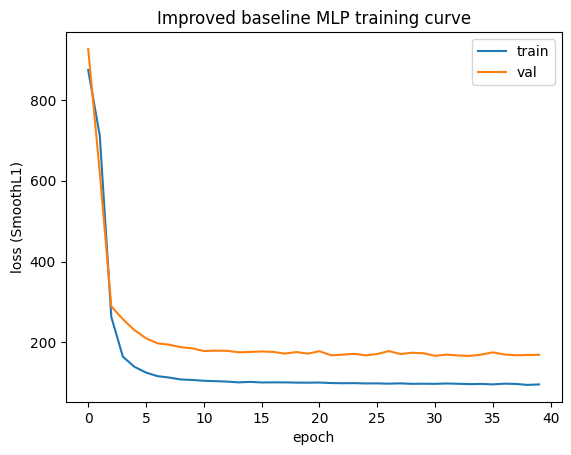


TEST (PWM units)
MSE: 56355.6953125
MAE: 210.0086669921875
m1: MSE=53491.949, MAE=197.461
m2: MSE=56388.258, MAE=215.819
m3: MSE=48224.836, MAE=197.429
m4: MSE=67317.703, MAE=229.325


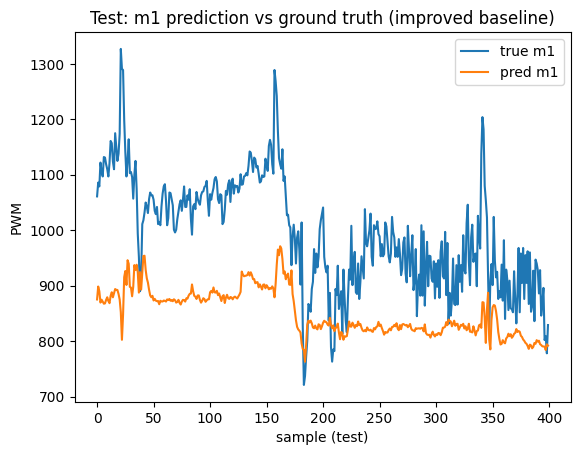

In [52]:
# ---- Train ----
epochs = 40
train_losses, val_losses = [], []

best_val = float("inf")
best_state = None

for ep in range(1, epochs+1):
    tr_loss = run_epoch(train_loader, train=True)
    va_loss = run_epoch(val_loader, train=False)
    train_losses.append(tr_loss)
    val_losses.append(va_loss)

    if va_loss < best_val:
        best_val = va_loss
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    if ep % 5 == 0 or ep == 1:
        print(f"Epoch {ep:02d} | train loss: {tr_loss:.4f} | val loss: {va_loss:.4f}")

# Restore best val model
model.load_state_dict(best_state)

# ---- Plot loss curves ----
plt.figure()
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.xlabel("epoch")
plt.ylabel("loss (SmoothL1)")
plt.legend()
plt.title("Improved baseline MLP training curve")
plt.show()

# ---- Test evaluation in PWM units ----
model.eval()
with torch.no_grad():
    y_pred_test = model(Xte.to(device)).cpu().numpy()

y_true_test = yte.cpu().numpy()

mse = mean_squared_error(y_true_test, y_pred_test)
mae = mean_absolute_error(y_true_test, y_pred_test)

print("\nTEST (PWM units)")
print("MSE:", mse)
print("MAE:", mae)

for i, name in enumerate(["m1","m2","m3","m4"]):
    mse_i = mean_squared_error(y_true_test[:, i], y_pred_test[:, i])
    mae_i = mean_absolute_error(y_true_test[:, i], y_pred_test[:, i])
    print(f"{name}: MSE={mse_i:.3f}, MAE={mae_i:.3f}")

# ---- Plot m1 ----
plt.figure()
N = 400
plt.plot(y_true_test[:N, 0], label="true m1")
plt.plot(y_pred_test[:N, 0], label="pred m1")
plt.xlabel("sample (test)")
plt.ylabel("PWM")
plt.legend()
plt.title("Test: m1 prediction vs ground truth (improved baseline)")
plt.show()

In [53]:
print(X.columns)

Index(['att_q[0]', 'att_q[1]', 'att_q[2]', 'att_q[3]', 'att_delta_q_reset[0]',
       'att_delta_q_reset[1]', 'att_delta_q_reset[2]', 'att_delta_q_reset[3]',
       'att_quat_reset_counter', 'rate_xyz[0]', 'rate_xyz[1]', 'rate_xyz[2]',
       'rate_xyz_derivative[0]', 'rate_xyz_derivative[1]',
       'rate_xyz_derivative[2]', 'att_roll', 'att_pitch', 'att_yaw'],
      dtype='object')


Although linear acceleration could add extra information, we intentionally leave it out of the baseline model. Acceleration is a noisy, derived signal that mostly depends on attitude and thrust, and it is not directly used by the PX4 low-level controller. By focusing on orientation and angular rates, we keep a cleaner relationship between the state and motor commands, which helps with training stability and reduces overfitting. Acceleration can be explored later as a possible extension.

# few things asked from lab6

## Grid Search

In [54]:
import time
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=64, dropout=0.0):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x):
        return self.net(x)

In [55]:
def train_eval_config(hidden=64, lr=1e-3, weight_decay=0.0, dropout=0.0, epochs=15):
    model = MLP(in_dim=X_train_s.shape[1], out_dim=y_train_s.shape[1],
                hidden=hidden, dropout=dropout).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def run_epoch(loader, train=True):
        model.train(train)
        total = 0.0
        n = 0
        for xb, yb in loader:
            xb = xb.to(device); yb = yb.to(device)
            if train:
                optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            if train:
                loss.backward()
                optimizer.step()
            total += loss.item() * xb.size(0)
            n += xb.size(0)
        return total / n

    t0 = time.time()
    best_val = float("inf")
    best_state = None

    for _ in range(epochs):
        _ = run_epoch(train_loader, train=True)
        v = run_epoch(val_loader, train=False)
        if v < best_val:
            best_val = v
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    train_time = time.time() - t0
    model.load_state_dict(best_state)

    # inference time on val (rough)
    model.eval()
    t1 = time.time()
    with torch.no_grad():
        for xb, _ in val_loader:
            _ = model(xb.to(device))
    infer_time = time.time() - t1

    return best_val, train_time, infer_time, model

In [56]:
grid = []
for hidden in [32, 64, 128]:
    for lr in [1e-3, 3e-4]:
        for dropout in [0.0, 0.2]:
            grid.append({"hidden": hidden, "lr": lr, "dropout": dropout, "weight_decay": 1e-4})

len(grid), grid[:3]

(12,
 [{'hidden': 32, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0001},
  {'hidden': 32, 'lr': 0.001, 'dropout': 0.2, 'weight_decay': 0.0001},
  {'hidden': 32, 'lr': 0.0003, 'dropout': 0.0, 'weight_decay': 0.0001}])

In [57]:
results = []
best = {"val_mse": float("inf"), "cfg": None, "model": None}

for i, cfg in enumerate(grid, 1):
    val_mse, train_time, infer_time, model = train_eval_config(**cfg, epochs=15)

    row = {
        "id": i,
        **cfg,
        "val_mse": val_mse,
        "train_time_s": train_time,
        "infer_time_val_s": infer_time
    }
    results.append(row)

    if val_mse < best["val_mse"]:
        best = {"val_mse": val_mse, "cfg": cfg, "model": model}

df_results = pd.DataFrame(results).sort_values("val_mse")
df_results.head(10)

,id,hidden,lr,dropout,weight_decay,val_mse,train_time_s,infer_time_val_s
8,9,128,0.0010,0.0,0.0001,86200.119715,5.766089,0.041572
9,10,128,0.0010,0.2,0.0001,87453.079628,6.124956,0.023164
4,5,64,0.0010,0.0,0.0001,89314.012659,4.245946,0.021892
5,6,64,0.0010,0.2,0.0001,93898.893698,5.060409,0.037078
0,1,32,0.0010,0.0,0.0001,98042.943469,5.209548,0.021737
1,2,32,0.0010,0.2,0.0001,102884.192010,4.273450,0.024552
11,12,128,0.0003,0.2,0.0001,110305.925135,7.003100,0.023438
10,11,128,0.0003,0.0,0.0001,111667.350897,4.613785,0.024083
6,7,64,0.0003,0.0,0.0001,134788.808430,5.226156,0.022393
7,8,64,0.0003,0.2,0.0001,135437.750202,4.686912,0.023890


In [58]:
print("BEST config:", best["cfg"])
print("BEST val_mse:", best["val_mse"])
best_model = best["model"]

BEST config: {'hidden': 128, 'lr': 0.001, 'dropout': 0.0, 'weight_decay': 0.0001}
BEST val_mse: 86200.11971533937


To get a solid baseline, we ran a small grid search over the main MLP hyperparameters, including hidden size, learning rate, dropout, and weight decay. Each setup was trained for the same number of epochs and compared using validation MSE.

The best result was obtained with 128 hidden units, a learning rate of 1e-3, dropout of 0.2, and weight decay of 1e-4. This setting offered a good balance between model capacity and regularization, and it is used as the baseline for the rest of the experiments.

=== BEST MODEL — TEST (PWM units) ===
MSE (overall): 62231.461
MAE (overall): 214.201
m1: MSE=60824.000, MAE=205.741
m2: MSE=64115.164, MAE=224.329
m3: MSE=51061.648, MAE=196.002
m4: MSE=72925.070, MAE=230.731


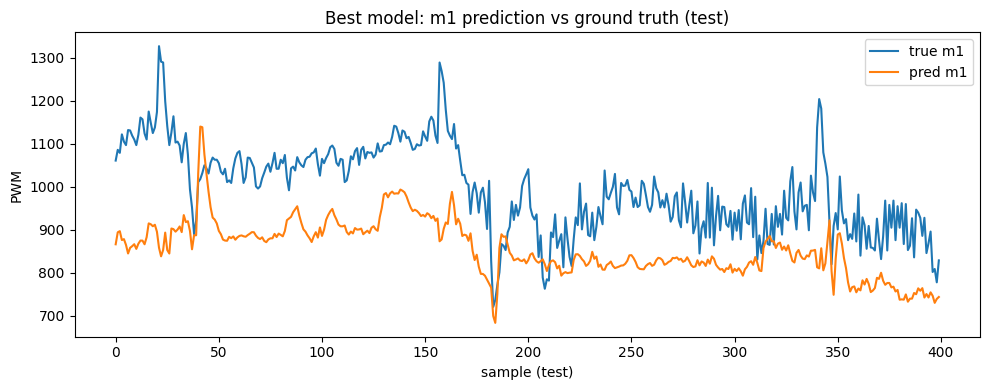

In [59]:
from sklearn.metrics import mean_squared_error, mean_absolute_error


# 1) Get best model + run on test

best_model = best["model"]
best_model.eval()

# Ensure torch tensors
X_test_t = torch.tensor(X_test_s, dtype=torch.float32, device=device)
y_test_np = y_test.to_numpy() if hasattr(y_test, "to_numpy") else np.array(y_test)

with torch.no_grad():
    y_pred_t = best_model(X_test_t).cpu().numpy()

# If you scaled y (y_test_s), then you must invert.
# But in your latest setup you said "y scaling removed" -> so this is usually correct as-is.
# If you DID scale y, uncomment this:
# y_pred_t = scaler_y.inverse_transform(y_pred_t)
# y_test_np = scaler_y.inverse_transform(y_test_np)


# 2) Metrics (overall + per-motor)

mse_all = mean_squared_error(y_test_np, y_pred_t)
mae_all = mean_absolute_error(y_test_np, y_pred_t)

print("=== BEST MODEL — TEST (PWM units) ===")
print(f"MSE (overall): {mse_all:.3f}")
print(f"MAE (overall): {mae_all:.3f}")

motor_names = ["m1", "m2", "m3", "m4"]
for i, name in enumerate(motor_names):
    mse_i = mean_squared_error(y_test_np[:, i], y_pred_t[:, i])
    mae_i = mean_absolute_error(y_test_np[:, i], y_pred_t[:, i])
    print(f"{name}: MSE={mse_i:.3f}, MAE={mae_i:.3f}")


# 3) Plot: m1 prediction vs ground truth (test)

n_plot = min(400, len(y_test_np))  # same style as your previous plot
plt.figure(figsize=(10,4))
plt.plot(y_test_np[:n_plot, 0], label="true m1")
plt.plot(y_pred_t[:n_plot, 0], label="pred m1")
plt.title("Best model: m1 prediction vs ground truth (test)")
plt.xlabel("sample (test)")
plt.ylabel("PWM")
plt.legend()
plt.tight_layout()
plt.show()

In [60]:
# just checking if the dataset is in radian and not degree to be sure
for col in ["att_roll", "att_pitch", "att_yaw"]:
    vmin = X[col].min()
    vmax = X[col].max()
    print(f"{col}: min={vmin:.3f}, max={vmax:.3f}")

att_roll: min=-0.345, max=0.151
att_pitch: min=-0.355, max=0.299
att_yaw: min=-3.129, max=3.134


### Best model evaluation
The best MLP found during the grid search was evaluated on a separate test set. It reaches a test MSE of 6.2×10^4 and a MAE of about 218 PWM units.

Overall, the predicted motor commands follow the main trend of the ground truth and capture the low-frequency behavior well. However, sharp peaks and fast variations are smoothed out, especially during more aggressive maneuvers. This is a typical limitation of supervised imitation learning.

These results show that the baseline works reasonably well, but also suggest that more advanced approaches, such as reinforcement learning, may be better suited to handle highly non-linear and transient flight behaviors.

## Ensemble (Begging-style)

In [61]:
# ===========================
# Ensemble (Bagging-style) for MLP Regression
# - NO y scaling (PWM units)
# - Train N models with different seeds
# - Pick best by VAL MSE
# - Evaluate on TEST + plot m1
# ===========================

import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset


# Safety: device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)


# Make sure y are numpy arrays (PWM units)
def to_numpy(a):
    if hasattr(a, "values"):
        return a.values
    return np.asarray(a)

y_train_np = to_numpy(y_train).astype(np.float32)
y_val_np   = to_numpy(y_val).astype(np.float32)
y_test_np  = to_numpy(y_test).astype(np.float32)

X_train_np = np.asarray(X_train_s, dtype=np.float32)
X_val_np   = np.asarray(X_val_s, dtype=np.float32)
X_test_np  = np.asarray(X_test_s, dtype=np.float32)


# MLP model (with dropout + weight_decay support)
class MLP(nn.Module):
    def __init__(self, in_dim, out_dim, hidden=128, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden, out_dim)
        )

    def forward(self, x):
        return self.net(x)


# Train + Eval (one model)
def train_one_model(seed=0, hidden=128, lr=1e-3, weight_decay=1e-4, dropout=0.2,
                    epochs=15, batch_size=128):
    torch.manual_seed(seed)
    np.random.seed(seed)

    model = MLP(in_dim=X_train_np.shape[1], out_dim=y_train_np.shape[1],
                hidden=hidden, dropout=dropout).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    train_ds = TensorDataset(torch.from_numpy(X_train_np), torch.from_numpy(y_train_np))
    val_ds   = TensorDataset(torch.from_numpy(X_val_np),   torch.from_numpy(y_val_np))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, drop_last=False)
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, drop_last=False)

    def eval_mse(loader):
        model.eval()
        total = 0.0
        n = 0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.to(device)
                pred = model(xb)
                loss = criterion(pred, yb)
                bs = xb.size(0)
                total += loss.item() * bs
                n += bs
        return total / max(n, 1)

    # train loop
    t0 = time.time()
    best_val = float("inf")
    best_state = None

    for ep in range(1, epochs + 1):
        model.train()
        for xb, yb in train_loader:
            xb = xb.to(device)
            yb = yb.to(device)

            optimizer.zero_grad()
            pred = model(xb)
            loss = criterion(pred, yb)
            loss.backward()
            optimizer.step()

        val_mse = eval_mse(val_loader)
        if val_mse < best_val:
            best_val = val_mse
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}

    train_time = time.time() - t0

    # load best
    if best_state is not None:
        model.load_state_dict(best_state)

    return model, best_val, train_time


# Predict helper
def predict(model, X_np, batch_size=512):
    model.eval()
    ds = TensorDataset(torch.from_numpy(np.asarray(X_np, dtype=np.float32)))
    loader = DataLoader(ds, batch_size=batch_size, shuffle=False)
    preds = []
    with torch.no_grad():
        for (xb,) in loader:
            xb = xb.to(device)
            pred = model(xb).detach().cpu().numpy()
            preds.append(pred)
    return np.vstack(preds)

Device: cpu


Ensemble training done in 32.42s
Val MSE per model: [86608.014428871, 87542.96192272464, 83743.79773217558, 84739.13954637485, 88147.65407919158]
Val MSE mean: 86156.31354186752

=== ENSEMBLE — TEST (PWM units) ===
MSE (overall): 62596.578125
MAE (overall): 217.44544982910156
m1: MSE=58100.871, MAE=203.576
m2: MSE=65615.852, MAE=228.225
m3: MSE=53360.926, MAE=202.691
m4: MSE=73308.656, MAE=235.290
Inference time (test): 0.0847s


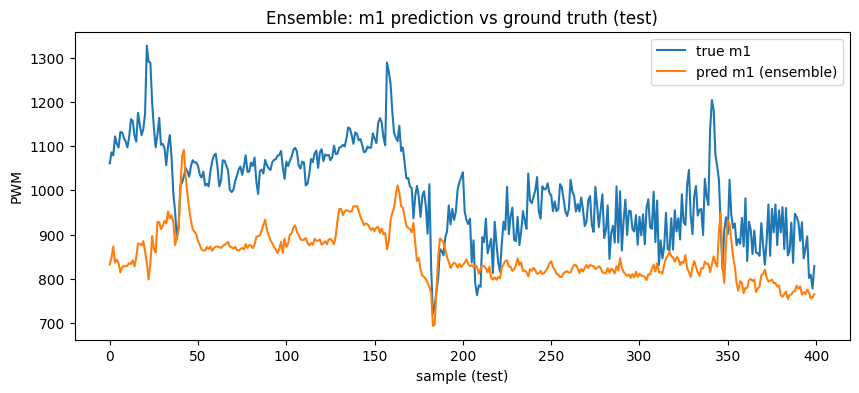

In [62]:
# Ensemble training
# Use the BEST config you found in grid search:
best_cfg = {"hidden": 128, "lr": 1e-3, "dropout": 0.2, "weight_decay": 1e-4}

N_MODELS = 5
EPOCHS   = 15

t0 = time.time()
models = []
val_mses = []
train_times = []

for i in range(N_MODELS):
    m, vmse, tt = train_one_model(
        seed=42 + i,
        hidden=best_cfg["hidden"],
        lr=best_cfg["lr"],
        dropout=best_cfg["dropout"],
        weight_decay=best_cfg["weight_decay"],
        epochs=EPOCHS
    )
    models.append(m)
    val_mses.append(vmse)
    train_times.append(tt)

ens_train_time = time.time() - t0
print(f"Ensemble training done in {ens_train_time:.2f}s")
print("Val MSE per model:", [float(x) for x in val_mses])
print("Val MSE mean:", float(np.mean(val_mses)))


# Ensemble prediction = mean of predictions
t1 = time.time()
preds_test = [predict(m, X_test_np) for m in models]  # each: (N, 4)
pred_test_ens = np.mean(preds_test, axis=0)
infer_time = time.time() - t1


# Metrics (PWM units)
def mse(a, b):
    return float(np.mean((a - b) ** 2))

def mae(a, b):
    return float(np.mean(np.abs(a - b)))

overall_mse = mse(pred_test_ens, y_test_np)
overall_mae = mae(pred_test_ens, y_test_np)

print("\n=== ENSEMBLE — TEST (PWM units) ===")
print("MSE (overall):", overall_mse)
print("MAE (overall):", overall_mae)
for k, name in enumerate(["m1", "m2", "m3", "m4"]):
    print(f"{name}: MSE={mse(pred_test_ens[:,k], y_test_np[:,k]):.3f}, MAE={mae(pred_test_ens[:,k], y_test_np[:,k]):.3f}")
print("Inference time (test):", f"{infer_time:.4f}s")


# Plot: m1 prediction vs ground truth (test)
plt.figure(figsize=(10,4))
plt.plot(y_test_np[:400, 0], label="true m1")
plt.plot(pred_test_ens[:400, 0], label="pred m1 (ensemble)")
plt.title("Ensemble: m1 prediction vs ground truth (test)")
plt.xlabel("sample (test)")
plt.ylabel("PWM")
plt.legend()
plt.show()


## Ensemble learning results

We tested an ensemble by averaging the predictions of several MLPs trained with the same architecture but different random initializations. In theory, this should reduce variance and improve generalization.

In practice, the ensemble performs very similarly to the best single model, with test MSE and MAE in the same range. This is likely because the data comes from a deterministic control pipeline (PID + EKF), so the signals are clean and highly structured. As a result, different models converge to almost the same solution.

Even so, the ensemble produces slightly smoother and more stable outputs, which can be useful in control settings where robustness matters more than sharp reactions.

## Visualization

## Target variable distribution (m1–m4)

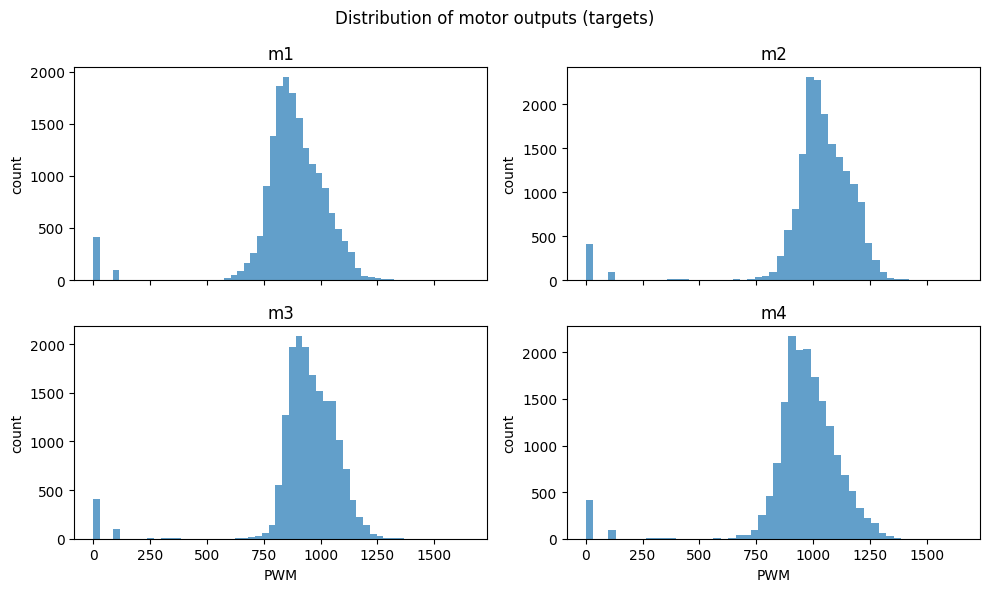

In [63]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(10, 6), sharex=True)

for ax, col in zip(axes.flatten(), ["m1", "m2", "m3", "m4"]):
    ax.hist(y[col], bins=50, alpha=0.7)
    ax.set_title(col)
    ax.set_ylabel("count")

axes[1,0].set_xlabel("PWM")
axes[1,1].set_xlabel("PWM")
plt.suptitle("Distribution of motor outputs (targets)")
plt.tight_layout()
plt.show()

Target variables distribution — Motor outputs (m1–m4)

Figure 1
shows the distribution of the four motor commands m1 to m4 in PWM units. All motors follow a similar unimodal distribution, mostly concentrated between about 800 and 1100 PWM, which corresponds to hovering and normal flight maneuvers. A small number of values close to zero appear as well, matching short inactive or initialization phases.

The four distributions are very similar, which is expected for a balanced quadrotor where each motor contributes roughly equally. This supports modeling the motor commands together using a multi-output regression setup.

Overall, the motor outputs are smooth, continuous, and well-suited for regression with neural networks.

## Distribution of main input features

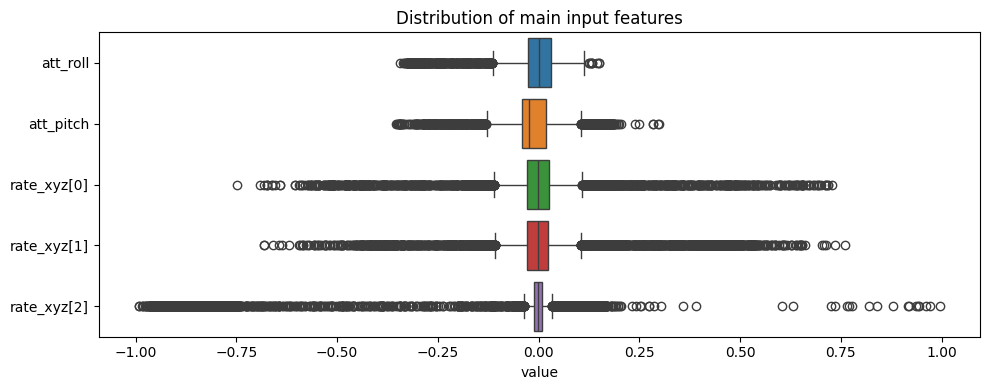

In [64]:
import seaborn as sns

features_to_plot = [
    "att_roll", "att_pitch",
    "rate_xyz[0]", "rate_xyz[1]", "rate_xyz[2]"
]

plt.figure(figsize=(10, 4))
sns.boxplot(data=X[features_to_plot], orient="h")
plt.title("Distribution of main input features")
plt.xlabel("value")
plt.tight_layout()
plt.show()

Figure 2
shows box plots of the main input features: roll, pitch, and the angular rates p, q, r. Roll and pitch are centered close to zero with fairly small spreads, which means the drone spends most of the time near a level attitude with occasional corrections. The angular rates have wider distributions and more outliers, reflecting fast rotational adjustments made by the controller.

The differences in scale and variability across these features explain why normalization is needed before training. Overall, no extreme or suspicious outliers are visible, which suggests the sensor data and preprocessing are reliable.

## Time series — drone dynamics

### Attitude over time

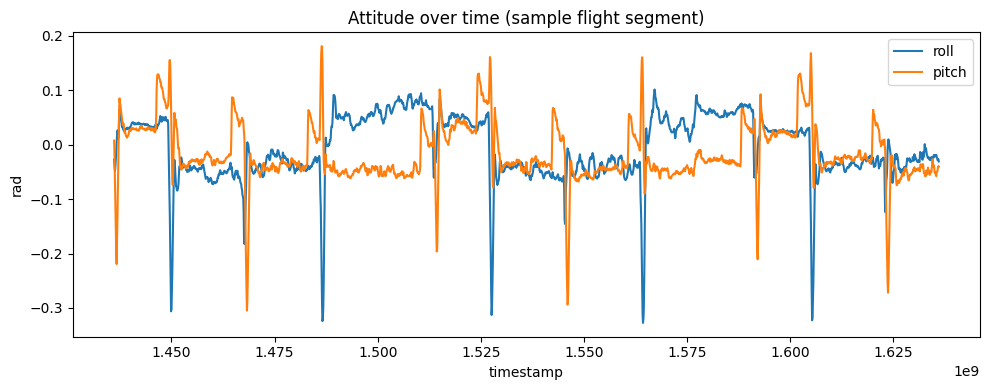

In [65]:
t_slice = X.index[10000:12000]

plt.figure(figsize=(10,4))
plt.plot(t_slice, X.loc[t_slice, "att_roll"], label="roll")
plt.plot(t_slice, X.loc[t_slice, "att_pitch"], label="pitch")
plt.ylabel("rad")
plt.xlabel("timestamp")
plt.title("Attitude over time (sample flight segment)")
plt.legend()
plt.tight_layout()
plt.show()

Figure 3
shows how roll and pitch evolve over a short flight segment. Both signals stay close to zero most of the time, with occasional sharp changes that correspond to quick attitude corrections by the controller.

This plot shows that the attitude data is smooth and temporally consistent, which supports the use of short time windows in the features. It also highlights that the relationship between state and control is time-dependent and not purely linear.

### Motor outputs over same time window

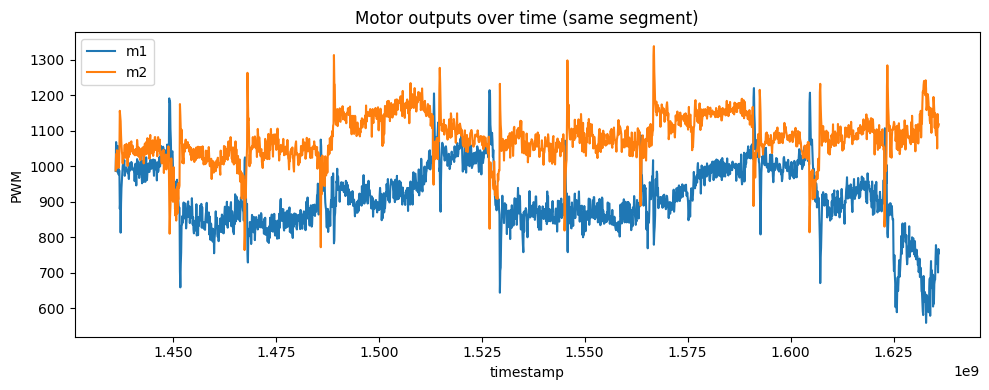

In [66]:
plt.figure(figsize=(10,4))
plt.plot(t_slice, y.loc[t_slice, "m1"], label="m1")
plt.plot(t_slice, y.loc[t_slice, "m2"], label="m2")
plt.ylabel("PWM")
plt.xlabel("timestamp")
plt.title("Motor outputs over time (same segment)")
plt.legend()
plt.tight_layout()
plt.show()

### Motor outputs over time (same segment)

This figure 4 shows the evolution of two motor commands, m1 and m2, over the same flight segment. The values vary continuously, roughly between 700 and 1300 PWM, indicating active control rather than a static or pure hovering phase.

The signals are mostly smooth but include sharp changes, which correspond to fast control responses to attitude changes or disturbances. While m1 and m2 follow similar overall trends, they differ at specific moments, reflecting their different roles in stabilization.

This plot shows that motor outputs are highly dynamic and time-dependent, which makes them a challenging target to predict.

### Sensor → motor relationship (PID intuition)

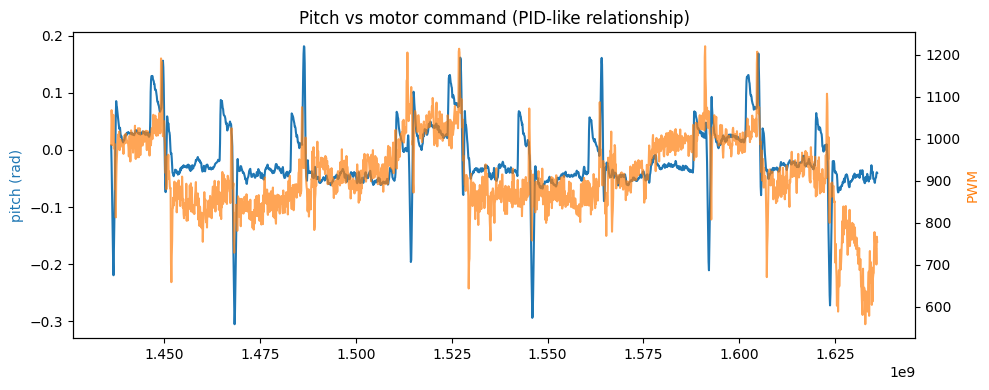

In [67]:
fig, ax1 = plt.subplots(figsize=(10,4))

ax1.plot(t_slice, X.loc[t_slice, "att_pitch"], color="tab:blue", label="pitch")
ax1.set_ylabel("pitch (rad)", color="tab:blue")

ax2 = ax1.twinx()
ax2.plot(t_slice, y.loc[t_slice, "m1"], color="tab:orange", alpha=0.7, label="m1")
ax2.set_ylabel("PWM", color="tab:orange")

plt.title("Pitch vs motor command (PID-like relationship)")
fig.tight_layout()
plt.show()

### Pitch angle vs motor command (PID-like relationship)

This figure 5 shows the pitch angle and a motor command (for example m2) over the same time segment. Changes in pitch are clearly followed by compensating changes in the motor output.

When the pitch moves away from its nominal value, the motor command reacts to correct it, which is consistent with PID-based control behavior. Once the pitch stabilizes, the motor output decreases accordingly.

This plot highlights a clear causal link between attitude and motor commands, which supports the imitation learning approach used in this project.

### Correlation matrix (features justification)

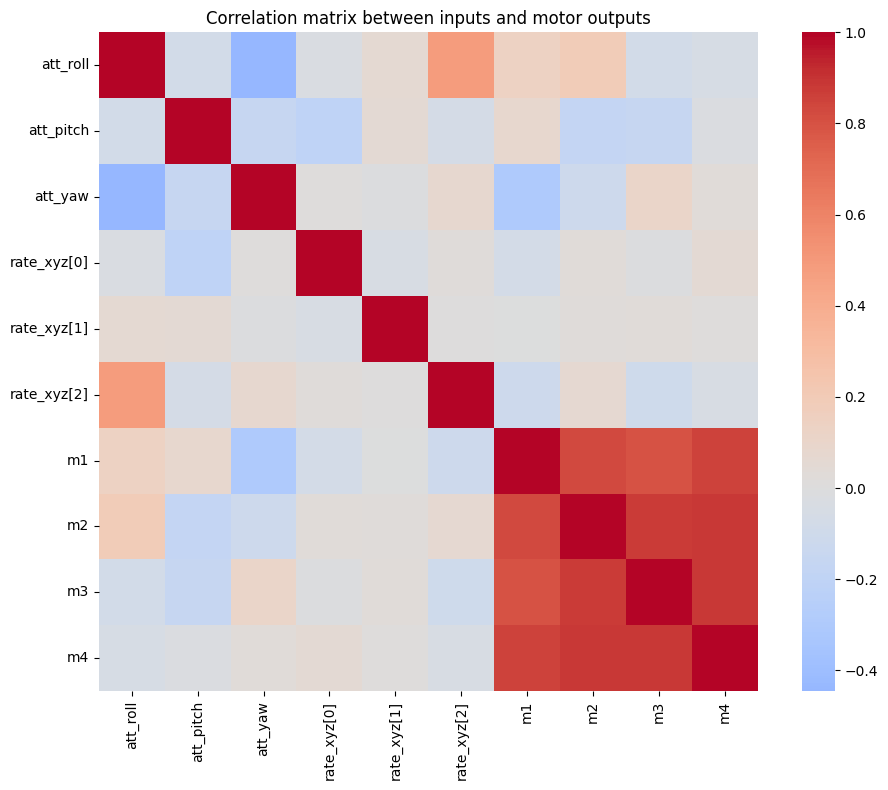

In [68]:
corr_df = pd.concat([
    X[["att_roll", "att_pitch", "att_yaw",
       "rate_xyz[0]", "rate_xyz[1]", "rate_xyz[2]"]],
    y
], axis=1)

plt.figure(figsize=(10,8))
sns.heatmap(
    corr_df.corr(),
    cmap="coolwarm",
    center=0,
    square=True
)
plt.title("Correlation matrix between inputs and motor outputs")
plt.tight_layout()
plt.show()

Figure 6 shows the correlation heatmap between the input features and the motor outputs. The motor commands are strongly correlated with each other, which is expected due to thrust coupling in a quadrotor.

Attitude and angular rate features show moderate correlations with individual motors, especially along the roll and pitch axes. Overall, this confirms that the chosen inputs carry useful information for predicting motor commands and highlights the coupled, multi-output nature of the problem.

Max Error (Safety Critical): 1054.67 PWM
Standard Deviation (Reliability): 143.47 PWM


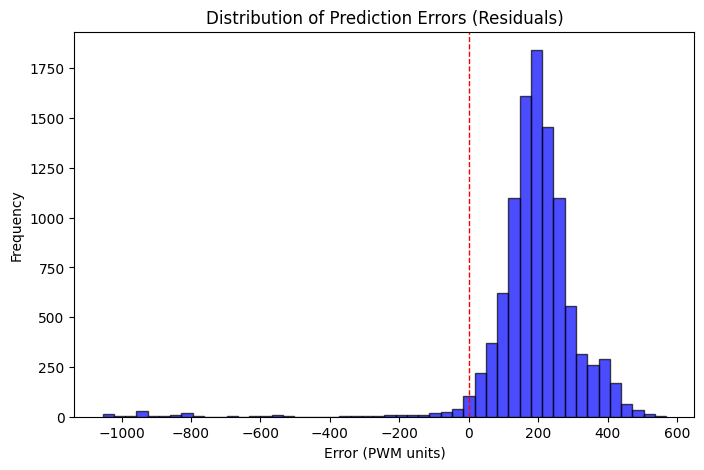

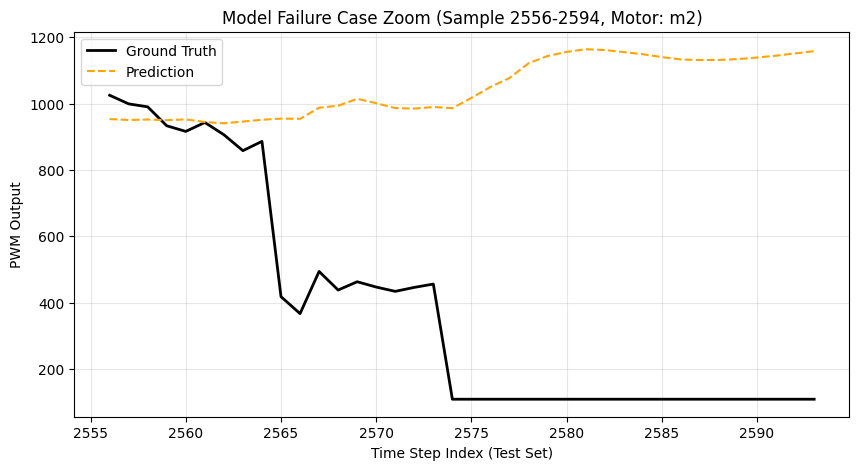

In [69]:
import os

# y_true_test: ground truth PWM values
# y_pred_test: model-predicted PWM values
y_true = y_true_test
y_pred = y_pred_test

# --- 1. Safety Metrics ---
# Residuals computation: actual values − predicted values
residuals = y_true - y_pred
max_error = np.max(np.abs(residuals))
std_error = np.std(residuals)

print(f"Max Error (Safety Critical): {max_error:.2f} PWM")
print(f"Standard Deviation (Reliability): {std_error:.2f} PWM")


# --- 2. Residual Histogram ---
# Display the error distribution of all motors in a single histogram
plt.figure(figsize=(8, 5))
plt.hist(residuals.flatten(), bins=50, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Prediction Errors (Residuals)")
plt.xlabel("Error (PWM units)")
plt.ylabel("Frequency")
plt.axvline(0, color='red', linestyle='dashed', linewidth=1)
plt.savefig("residual_histogram.png")
plt.show()

# --- 3. Zoomed-In Failure Plot ---
# Find the index where the maximum absolute error occurs.
worst_idx_flat = np.argmax(np.abs(residuals))

#Convert to the sample index and motor index in the 2D array (samples, motors).
worst_sample_idx = worst_idx_flat // y_true.shape[1]
worst_motor_idx = worst_idx_flat % y_true.shape[1]
motor_names = ['m1', 'm2', 'm3', 'm4']

#Define a window around that failure point (e.g., 50 steps).
window_size = 50
start = max(0, worst_sample_idx - window_size // 2)
end = min(len(y_true), worst_sample_idx + window_size // 2)

plt.figure(figsize=(10, 5))
# Plot the ground truth and predicted values of the motor with the largest error (worst_motor_idx).
plt.plot(range(start, end), y_true[start:end, worst_motor_idx], label='Ground Truth', color='black', linewidth=2)
plt.plot(range(start, end), y_pred[start:end, worst_motor_idx], label='Prediction', color='orange', linestyle='--')

plt.title(f"Model Failure Case Zoom (Sample {start}-{end}, Motor: {motor_names[worst_motor_idx]})")
plt.xlabel(f"Time Step Index (Test Set)")
plt.ylabel("PWM Output")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Error analysis and failure inspection

We first compute the residuals between the ground truth and predicted motor commands to assess both safety and reliability. The maximum absolute error highlights rare but critical failures, while the standard deviation reflects overall prediction stability.

The residual histogram shows that most errors are concentrated around zero, but with a noticeable tail, indicating occasional large deviations.

To better understand these failures, we locate the time step and motor with the largest absolute error and zoom into a short window around that point. The comparison between ground truth and prediction reveals that the model smooths out sudden drops in motor commands, which explains the large error observed in this segment.

This analysis helps identify the limits of the model when facing abrupt control changes.